In [70]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [71]:
df = pd.read_csv('trades.csv')
df

,Unnamed: 0,trade_id,product_id,price,size,time,side,exchange,bid,ask,trades,best_bid,best_ask
0,0,581156882,ETH-USD,3940.75,1.010911,2024-12-12 03:51:55.653508+00:00,BUY,NaN,NaN,NaN,NaN,NaN,NaN
1,1,581156408,ETH-USD,3940.49,0.082890,2024-12-12 03:51:40.969747+00:00,SELL,NaN,NaN,NaN,NaN,NaN,NaN
2,2,581156040,ETH-USD,3946.00,1.638540,2024-12-12 03:51:25.790657+00:00,BUY,NaN,NaN,NaN,NaN,NaN,NaN
3,3,581155828,ETH-USD,3948.16,0.014420,2024-12-12 03:51:10.997689+00:00,SELL,NaN,NaN,NaN,NaN,NaN,NaN
4,4,581155506,ETH-USD,3945.35,0.014200,2024-12-12 03:50:55.605769+00:00,SELL,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4822,4995,580639974,ETH-USD,3680.90,0.013448,2024-12-11 07:03:10.284759+00:00,SELL,NaN,NaN,NaN,NaN,NaN,NaN
4823,4996,580639920,ETH-USD,3680.59,0.059300,2024-12-11 07:02:55.640251+00:00,SELL,NaN,NaN,NaN,NaN,NaN,NaN
4824,4997,580639893,ETH-USD,3680.81,0.013675,2024-12-11 07:02:40.964713+00:00,SELL,NaN,NaN,NaN,NaN,NaN,NaN
4825,4998,580639829,ETH-USD,3680.57,0.133349,2024-12-11 07:02:25.380236+00:00,BUY,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
#drop unneeded columns
columns_to_drop = ['Unnamed: 0', 'exchange', 'bid', 'ask', 'trades', 'best_bid', 'best_ask', 'trade_id', 'product_id']

# Check for existing columns before dropping to avoid KeyErrors
df_trades = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

In [73]:
#change side column to SELL = 0 and BUY = 1
df_trades['side'] = df_trades['side'].map({'SELL': 0, 'BUY': 1})
df_trades

,price,size,time,side
0,3940.75,1.010911,2024-12-12 03:51:55.653508+00:00,1.0
1,3940.49,0.082890,2024-12-12 03:51:40.969747+00:00,0.0
2,3946.00,1.638540,2024-12-12 03:51:25.790657+00:00,1.0
3,3948.16,0.014420,2024-12-12 03:51:10.997689+00:00,0.0
4,3945.35,0.014200,2024-12-12 03:50:55.605769+00:00,0.0
...,...,...,...,...
4822,3680.90,0.013448,2024-12-11 07:03:10.284759+00:00,0.0
4823,3680.59,0.059300,2024-12-11 07:02:55.640251+00:00,0.0
4824,3680.81,0.013675,2024-12-11 07:02:40.964713+00:00,0.0
4825,3680.57,0.133349,2024-12-11 07:02:25.380236+00:00,1.0


In [74]:
# Ensure time column is sorted
df_trades = df_trades.sort_values('time')

# Scale the 'price' column
scaler = MinMaxScaler(feature_range=(0, 1))
df_trades['price_scaled'] = scaler.fit_transform(df_trades[['price']])

# Create sequences of data for LSTM
sequence_length = 10  # Sequence of 10 observations
forecast_steps = 5  # Predict 5 steps into the future

In [75]:
# split data into sequences and X and y
X = []
y = []

prices = df_trades['price_scaled'].values

for i in range(len(prices) - sequence_length - forecast_steps):
    X.append(prices[i:i + sequence_length])
    y.append(prices[i + sequence_length + forecast_steps - 1])

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [76]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [77]:
# Build the LSTM model with L2 regularization and LeakyReLU
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='tanh', return_sequences=True, kernel_regularizer=l1(0.001)),
    Dropout(0.15),
    LSTM(50, activation='tanh', kernel_regularizer=l2(0.001)),
    Dropout(0.15),
    Dense(1024, activation=None, kernel_regularizer=l2(0.001)),  # Add L2 regularization
    LeakyReLU(alpha=0.3),  # LeakyReLU activation
    Dropout(0.15),
    Dense(1)
])

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10, 50)            10400     
                                                                 
 dropout_18 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_19 (Dropout)        (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 1024)              52224     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout_20 (Dropout)        (None, 1024)             

In [78]:
# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/150
121/121 [==============================] - 2s 7ms/step - loss: 0.0921 - val_loss: 0.0263
Epoch 2/150
121/121 [==============================] - 1s 4ms/step - loss: 0.0151 - val_loss: 0.0089
Epoch 3/150
121/121 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 4/150
121/121 [==============================] - 1s 4ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 5/150
121/121 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 6/150
121/121 [==============================] - 1s 4ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/150
121/121 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 8/150
121/121 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 9/150
121/121 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 10/150
121/121 [==============================] - 1s 4ms/step - loss: 0.0019 - val_lo

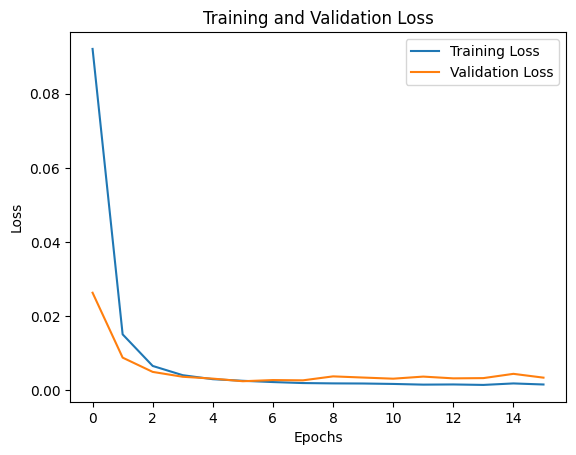

In [79]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
# Make predictions on the test set
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions and test labels to get original prices
predictions = scaler.inverse_transform(predictions_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

31/31 [==============================] - 0s 1ms/step


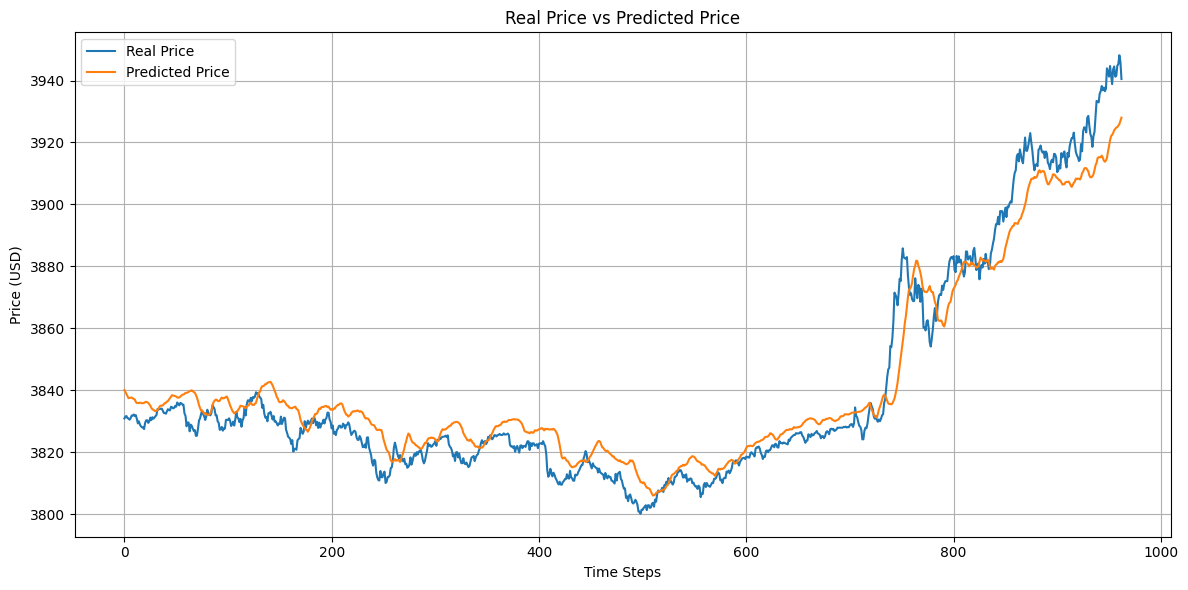

In [83]:
# Plot the real vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Real Price", linestyle='-')
plt.plot(predictions, label="Predicted Price", linestyle='-')
plt.title("Real Price vs Predicted Price")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()